In [1]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import precision_score,f1_score,recall_score,classification_report,accuracy_score
import joblib
from imblearn.over_sampling import SMOTE
from tqdm import tqdm


In [3]:
data_tr1=pd.read_csv("new_train_sample.csv")

In [4]:
data_tr1

,Unnamed: 0,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,5172780,1709396985476,26,18583,687462,2024-06-06T05:56:47.000Z,31,813,Malware,NaN,...,NaN,NaN,5.0,66.0,NaN,Suspicious,Malicious,242.0,1445.0,10630.0
1,8470561,927712939180,33,5065,3990,2024-06-03T10:45:09.000Z,38,25,Impact,NaN,...,NaN,NaN,5.0,66.0,NaN,NaN,NaN,242.0,1445.0,10630.0
2,5897583,1090921697002,201,150787,807590,2024-06-13T03:36:40.000Z,419,444,Execution,T1047;T1059;T1053;T1569;T1059.001;T1053.002;T1...,...,NaN,Destination,5.0,66.0,NaN,NaN,NaN,242.0,1445.0,10630.0
3,3288552,1434519079555,204,108287,28575,2024-06-08T16:54:57.000Z,44,1233,SuspiciousActivity,NaN,...,NaN,NaN,5.0,66.0,NaN,Suspicious,Suspicious,242.0,1445.0,10630.0
4,4060961,1005022347708,54,528202,1458226,2024-06-09T02:48:01.000Z,102,58829,Exfiltration,NaN,...,NaN,NaN,5.0,66.0,NaN,NaN,NaN,242.0,1445.0,10630.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83820,3114857,206158430958,127,108,1063889,2024-06-13T05:15:44.000Z,0,0,InitialAccess,T1078;T1078.004,...,NaN,NaN,5.0,66.0,NaN,NaN,NaN,0.0,11.0,8.0
83821,3909292,1194000908435,11,406756,1056929,2024-06-05T12:09:22.000Z,0,0,InitialAccess,T1078;T1078.004,...,NaN,NaN,5.0,66.0,NaN,NaN,NaN,242.0,1445.0,10630.0
83822,4594188,1228360651563,38,9848,6649,2024-06-11T22:48:05.000Z,488,270,CredentialAccess,NaN,...,NaN,NaN,5.0,66.0,NaN,NaN,NaN,242.0,1445.0,10630.0
83823,7748148,1511828490209,23,417,107322,2024-06-06T14:24:09.000Z,4,3,InitialAccess,NaN,...,NaN,NaN,5.0,66.0,NaN,NaN,NaN,16.0,1445.0,10630.0


In [5]:
list(data_tr1.columns)  # full column view ("/content/new_train_sample.csv")

['Unnamed: 0',
 'Id',
 'OrgId',
 'IncidentId',
 'AlertId',
 'Timestamp',
 'DetectorId',
 'AlertTitle',
 'Category',
 'MitreTechniques',
 'IncidentGrade',
 'ActionGrouped',
 'ActionGranular',
 'EntityType',
 'EvidenceRole',
 'DeviceId',
 'Sha256',
 'IpAddress',
 'Url',
 'AccountSid',
 'AccountUpn',
 'AccountObjectId',
 'AccountName',
 'DeviceName',
 'NetworkMessageId',
 'EmailClusterId',
 'RegistryKey',
 'RegistryValueName',
 'RegistryValueData',
 'ApplicationId',
 'ApplicationName',
 'OAuthApplicationId',
 'ThreatFamily',
 'FileName',
 'FolderPath',
 'ResourceIdName',
 'ResourceType',
 'Roles',
 'OSFamily',
 'OSVersion',
 'AntispamDirection',
 'SuspicionLevel',
 'LastVerdict',
 'CountryCode',
 'State',
 'City']

In [6]:
pd.set_option('display.max_columns', None)
data_tr1.head(1)

,Unnamed: 0,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,ActionGrouped,ActionGranular,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,EmailClusterId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,ThreatFamily,FileName,FolderPath,ResourceIdName,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,5172780,1709396985476,26,18583,687462,2024-06-06T05:56:47.000Z,31,813,Malware,NaN,BenignPositive,NaN,NaN,File,Related,98799,1296.0,360606.0,160396.0,441377.0,673934.0,425863.0,453297.0,153085.0,529644.0,NaN,1631.0,635.0,860.0,2251.0,3421.0,881.0,Casdet,4132.0,4227.0,3586.0,NaN,NaN,5.0,66.0,NaN,Suspicious,Malicious,242.0,1445.0,10630.0


In [7]:
data_tr1.shape

(83825, 46)

In [8]:
data_tr1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83825 entries, 0 to 83824
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          83825 non-null  int64  
 1   Id                  83825 non-null  int64  
 2   OrgId               83825 non-null  int64  
 3   IncidentId          83825 non-null  int64  
 4   AlertId             83825 non-null  int64  
 5   Timestamp           83825 non-null  object 
 6   DetectorId          83825 non-null  int64  
 7   AlertTitle          83825 non-null  int64  
 8   Category            83825 non-null  object 
 9   MitreTechniques     35548 non-null  object 
 10  IncidentGrade       83382 non-null  object 
 11  ActionGrouped       485 non-null    object 
 12  ActionGranular      485 non-null    object 
 13  EntityType          83825 non-null  object 
 14  EvidenceRole        83825 non-null  object 
 15  DeviceId            83825 non-null  int64  
 16  Sha2

## **Handling data**

In [10]:
(data_tr1.isnull().sum()/(len(data_tr1)))*100

,0
Unnamed: 0,0.000000
Id,0.000000
OrgId,0.000000
IncidentId,0.000000
AlertId,0.000000
Timestamp,0.000000
DetectorId,0.000000
AlertTitle,0.000000
Category,0.000000
MitreTechniques,57.592604


In [11]:
threshold= len(data_tr1)* 0.5   # removing 50% above null value
data_tr1=data_tr1.dropna(thresh=threshold,axis=1)

In [12]:
data_tr1.shape

(83825, 36)

In [13]:
data_tr1.duplicated().sum()

0

In [14]:
data_tr1.drop_duplicates(inplace=True)

<ipython-input-14-7376794d8279>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tr1.drop_duplicates(inplace=True)


In [15]:
data_tr1.isnull().sum()

,0
Unnamed: 0,0
Id,0
OrgId,0
IncidentId,0
AlertId,0
Timestamp,0
DetectorId,0
AlertTitle,0
Category,0
IncidentGrade,443


In [16]:
data_tr1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83825 entries, 0 to 83824
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          83825 non-null  int64  
 1   Id                  83825 non-null  int64  
 2   OrgId               83825 non-null  int64  
 3   IncidentId          83825 non-null  int64  
 4   AlertId             83825 non-null  int64  
 5   Timestamp           83825 non-null  object 
 6   DetectorId          83825 non-null  int64  
 7   AlertTitle          83825 non-null  int64  
 8   Category            83825 non-null  object 
 9   IncidentGrade       83382 non-null  object 
 10  EntityType          83825 non-null  object 
 11  EvidenceRole        83825 non-null  object 
 12  DeviceId            83825 non-null  int64  
 13  Sha256              83824 non-null  float64
 14  IpAddress           83824 non-null  float64
 15  Url                 83824 non-null  float64
 16  Acco

In [17]:
data_tr1["IncidentGrade"].fillna(data_tr1["IncidentGrade"].mode()[0],inplace=True) # fill mode values for IncidentGrade

<ipython-input-17-1843a2b56e5a>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_tr1["IncidentGrade"].fillna(data_tr1["IncidentGrade"].mode()[0],inplace=True) # fill mode values for IncidentGrade
<ipython-input-17-1843a2b56e5a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tr1["IncidentGrade"].fillna(data_tr1["IncidentGrade"].mode

In [18]:
data_tr1.IncidentGrade.unique()

array(['BenignPositive', 'TruePositive', 'FalsePositive'], dtype=object)

In [19]:
data_tr1['Timestamp']=pd.to_datetime(data_tr1['Timestamp']) # data clean Timestamp

<ipython-input-19-74a0ba3c43fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tr1['Timestamp']=pd.to_datetime(data_tr1['Timestamp']) # data clean Timestamp


In [20]:
data_tr1['Timestamp'].head()

,Timestamp
0,2024-06-06 05:56:47+00:00
1,2024-06-03 10:45:09+00:00
2,2024-06-13 03:36:40+00:00
3,2024-06-08 16:54:57+00:00
4,2024-06-09 02:48:01+00:00


In [21]:
data_tr1["Day"]=data_tr1["Timestamp"].dt.day
data_tr1["Month"]=data_tr1["Timestamp"].dt.month
data_tr1["Year"]=data_tr1["Timestamp"].dt.year
data_tr1["Hour"]=data_tr1["Timestamp"].dt.hour
data_tr1["Time"]=data_tr1["Timestamp"].dt.time

<ipython-input-21-50614ca389ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tr1["Day"]=data_tr1["Timestamp"].dt.day
<ipython-input-21-50614ca389ff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tr1["Month"]=data_tr1["Timestamp"].dt.month
<ipython-input-21-50614ca389ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [22]:
data_tr1.drop("Timestamp",axis=1,inplace=True)   # doprring timestamp column
print(data_tr1.head())

   Unnamed: 0             Id  OrgId  IncidentId  AlertId  DetectorId  \
0     5172780  1709396985476     26       18583   687462          31   
1     8470561   927712939180     33        5065     3990          38   
2     5897583  1090921697002    201      150787   807590         419   
3     3288552  1434519079555    204      108287    28575          44   
4     4060961  1005022347708     54      528202  1458226         102   

   AlertTitle            Category   IncidentGrade EntityType EvidenceRole  \
0         813             Malware  BenignPositive       File      Related   
1          25              Impact  BenignPositive    Machine     Impacted   
2         444           Execution  BenignPositive    Machine     Impacted   
3        1233  SuspiciousActivity    TruePositive       File      Related   
4       58829        Exfiltration  BenignPositive       File     Impacted   

   DeviceId    Sha256  IpAddress       Url  AccountSid  AccountUpn  \
0     98799    1296.0   360606.0  

<ipython-input-22-564c5023b487>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tr1.drop("Timestamp",axis=1,inplace=True)   # doprring timestamp column


In [23]:
data_tr1['IncidentGrade'].value_counts()

,count
IncidentGrade,
BenignPositive,36724
TruePositive,29222
FalsePositive,17879


In [24]:
data_tr1.Category.unique()

array(['Malware', 'Impact', 'Execution', 'SuspiciousActivity',
       'Exfiltration', 'InitialAccess', 'DefenseEvasion',
       'CommandAndControl', 'Discovery', 'Persistence',
       'CredentialAccess', 'LateralMovement', 'Ransomware',
       'UnwantedSoftware', 'PrivilegeEscalation', 'Exploit', 'Collection',
       'CredentialStealing'], dtype=object)

In [26]:
data_tr1.isnull().sum()

,0
Unnamed: 0,0
Id,0
OrgId,0
IncidentId,0
AlertId,0
DetectorId,0
AlertTitle,0
Category,0
IncidentGrade,0
EntityType,0


# **Data** **Visualization**

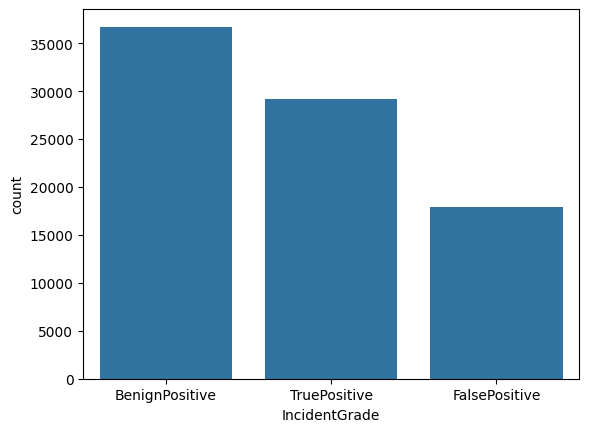

In [27]:
# Distribution of target variable
sns.countplot(x="IncidentGrade", data=data_tr1)
plt.show()

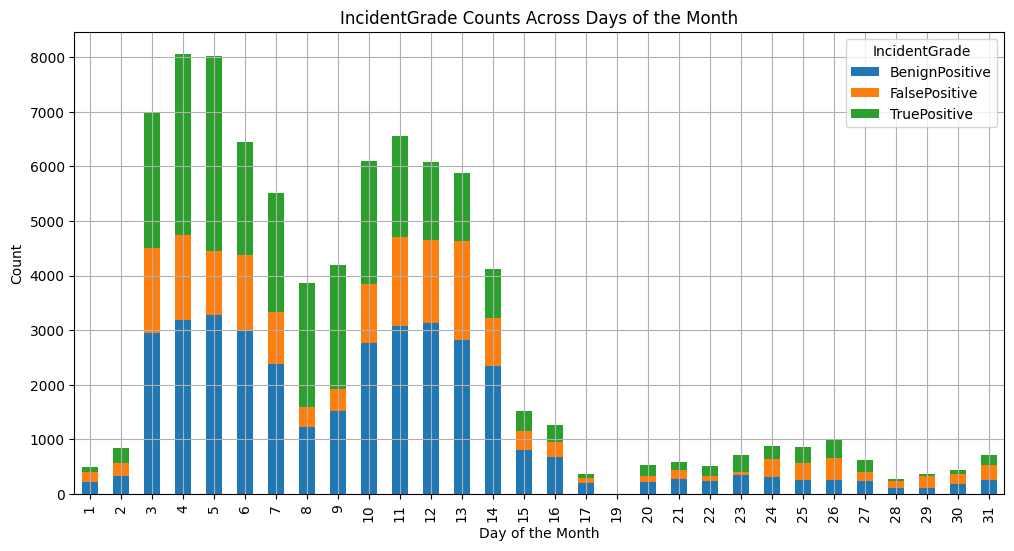

In [28]:
# Aggregate data
day_incident_grade = data_tr1.groupby(['Day', 'IncidentGrade']).size().unstack()

# Plot
day_incident_grade.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Day of the Month')
plt.ylabel('Count')
plt.title('IncidentGrade Counts Across Days of the Month')
plt.legend(title='IncidentGrade')
plt.grid(True)
plt.show()

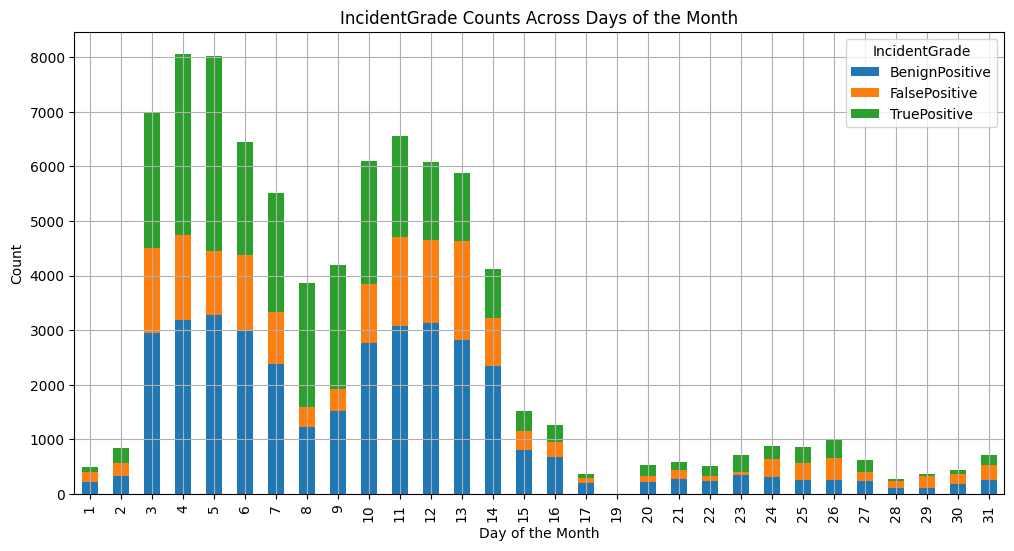

In [29]:
# Aggregate data
day_incident_grade = data_tr1.groupby(['Day', 'IncidentGrade']).size().unstack()

# Plot
day_incident_grade.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Day of the Month')
plt.ylabel('Count')
plt.title('IncidentGrade Counts Across Days of the Month')
plt.legend(title='IncidentGrade')
plt.grid(True)
plt.show()

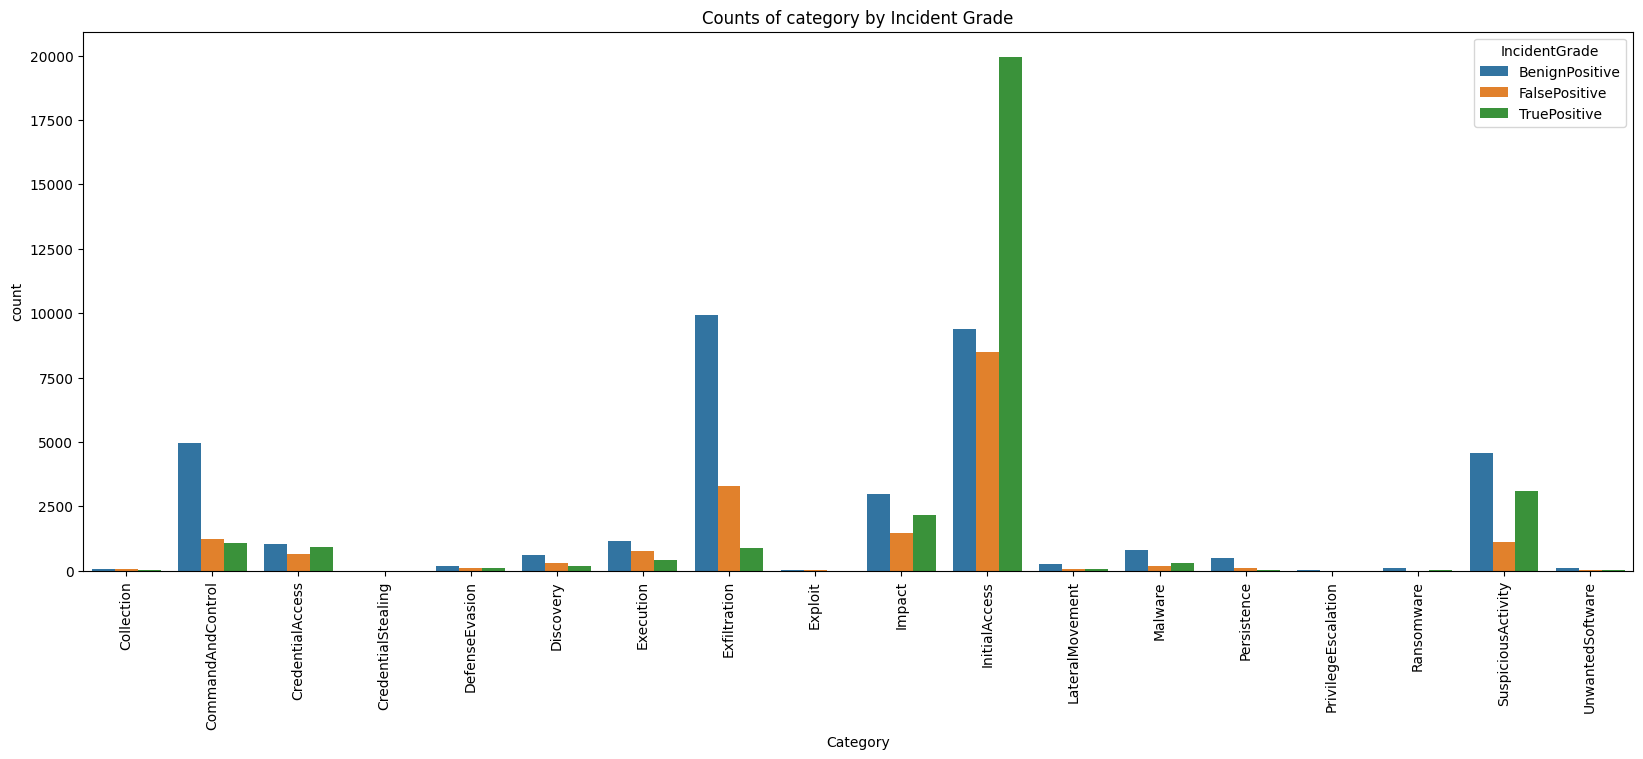

In [30]:
# Aggregate data
grouped_data=data_tr1.groupby(["Category","IncidentGrade"]).size().reset_index(name="count")

plt.figure(figsize=(20,7))
sns.barplot(data=grouped_data,x="Category", y="count", hue = "IncidentGrade")
plt.xticks(rotation=90)
plt.title("Counts of category by Incident Grade")
plt.show()

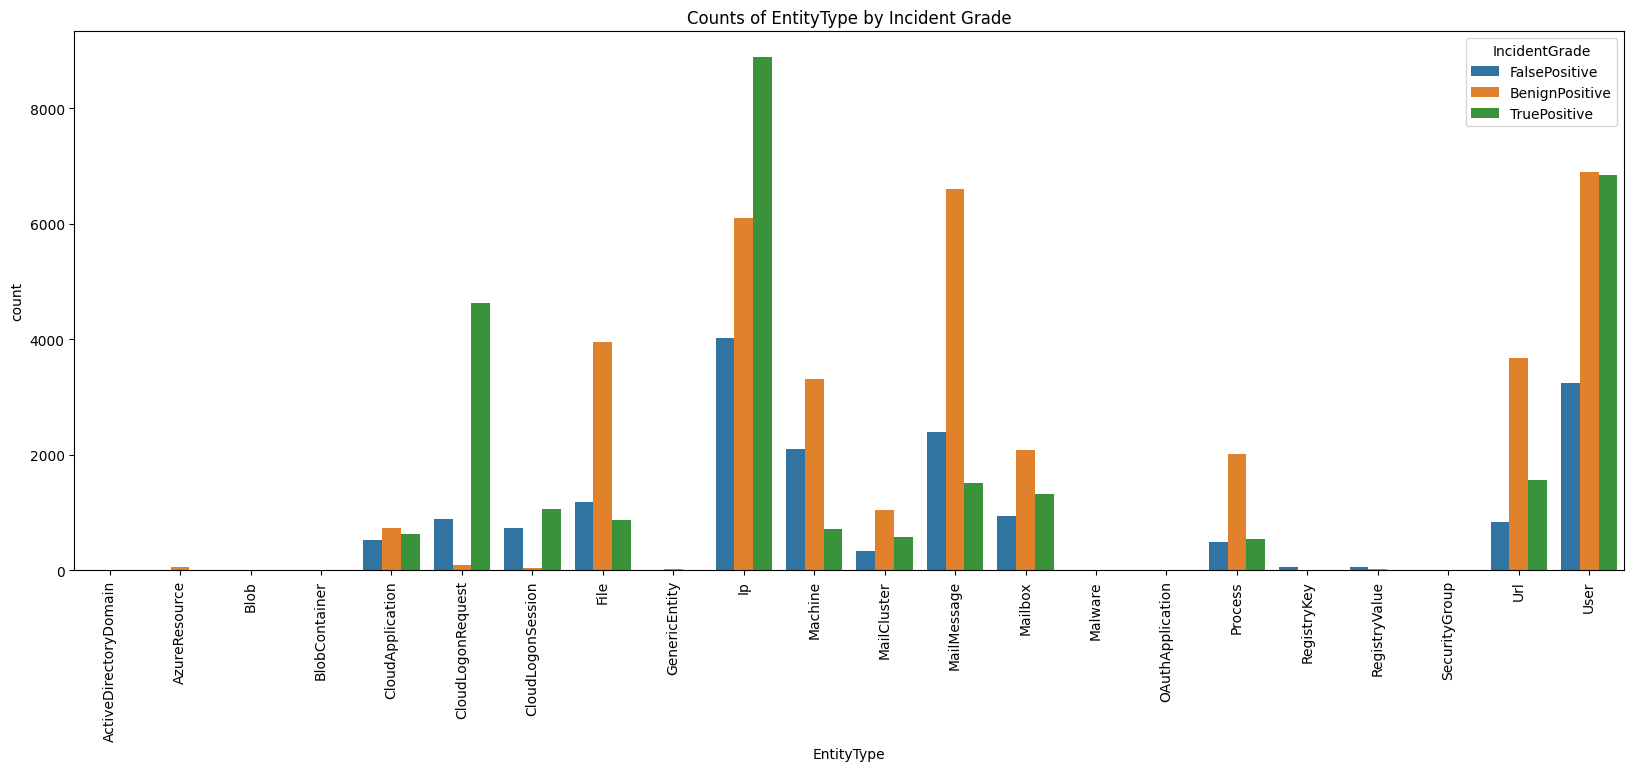

In [31]:
# Aggregate data
grouped_data=data_tr1.groupby(["EntityType","IncidentGrade"]).size().reset_index(name="count")

plt.figure(figsize=(20,7))
sns.barplot(data=grouped_data,x="EntityType", y="count", hue = "IncidentGrade")
plt.xticks(rotation=90)
plt.title("Counts of EntityType by Incident Grade")
plt.show()


In [32]:
# dropping 70% above correlated columns
data_tr1.drop(["Month","DeviceName","DeviceId","ResourceIdName","Unnamed: 0","OAuthApplicationId","NetworkMessageId"], axis =1 , inplace = True)

<ipython-input-32-9cd3b8fc7adf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tr1.drop(["Month","DeviceName","DeviceId","ResourceIdName","Unnamed: 0","OAuthApplicationId","NetworkMessageId"], axis =1 , inplace = True)


In [33]:

data_tr1['State'].fillna(data_tr1['State'].mode()[0], inplace=True)
data_tr1['CountryCode'].fillna(data_tr1['CountryCode'].mode()[0], inplace=True)
data_tr1['City'].fillna(data_tr1['City'].mode()[0], inplace=True)

<ipython-input-33-72ea5576f60c>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_tr1['State'].fillna(data_tr1['State'].mode()[0], inplace=True)
<ipython-input-33-72ea5576f60c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tr1['State'].fillna(data_tr1['State'].mode()[0], inplace=True)
<ipython-input-33-72ea5576f60c>:2: FutureWarnin

In [34]:
data_tr1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83825 entries, 0 to 83824
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 83825 non-null  int64  
 1   OrgId              83825 non-null  int64  
 2   IncidentId         83825 non-null  int64  
 3   AlertId            83825 non-null  int64  
 4   DetectorId         83825 non-null  int64  
 5   AlertTitle         83825 non-null  int64  
 6   Category           83825 non-null  object 
 7   IncidentGrade      83825 non-null  object 
 8   EntityType         83825 non-null  object 
 9   EvidenceRole       83825 non-null  object 
 10  Sha256             83824 non-null  float64
 11  IpAddress          83824 non-null  float64
 12  Url                83824 non-null  float64
 13  AccountSid         83824 non-null  float64
 14  AccountUpn         83824 non-null  float64
 15  AccountObjectId    83824 non-null  float64
 16  AccountName        838

# **Feature** **selection** **and** **correlation¶**

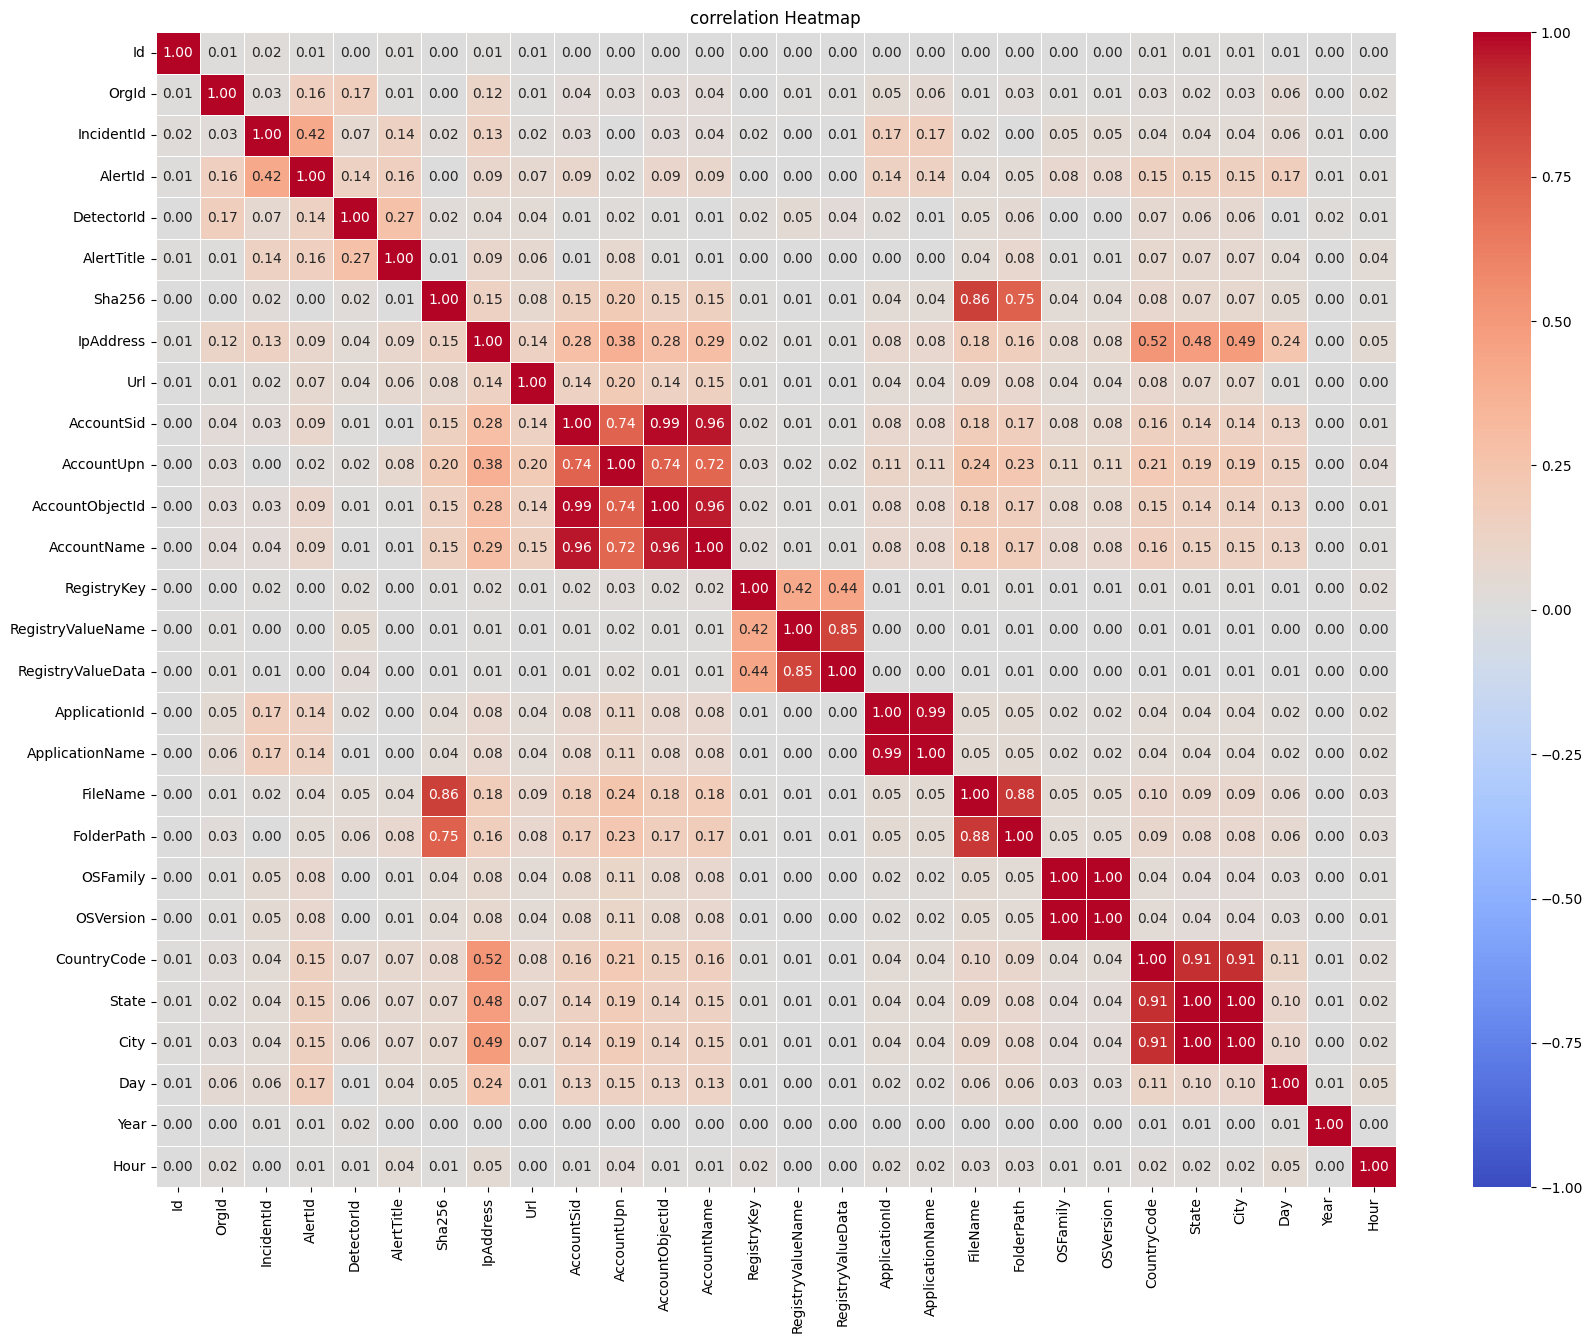

In [36]:
# selecting numerical col
numeric_df=data_tr1.select_dtypes(include=['number'])

corr_matrix= numeric_df.corr().abs()

# plot the heatmap
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix,annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, linewidths=0.5)
plt.title('correlation Heatmap')
plt.show()

In [37]:
# dropping 70% above correlated columns
data_tr1.drop(["CountryCode","Sha256","ApplicationName","RegistryValueName","AccountSid","AccountObjectId","FolderPath","AccountUpn"], axis =1 , inplace = True)

<ipython-input-37-d9a6cc5908e4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tr1.drop(["CountryCode","Sha256","ApplicationName","RegistryValueName","AccountSid","AccountObjectId","FolderPath","AccountUpn"], axis =1 , inplace = True)


In [38]:
# dropping 70% above correlated columns
data_tr1.drop(["RegistryKey","RegistryValueData","DetectorId","Id" ], axis =1 , inplace = True)

<ipython-input-38-92a70133bd5a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tr1.drop(["RegistryKey","RegistryValueData","DetectorId","Id" ], axis =1 , inplace = True)


In [39]:
# dropping 70% above correlated columns
data_tr1.drop(["OSFamily","OSVersion",'State','FileName','AccountName' ], axis =1 , inplace = True)

<ipython-input-39-5b4e9b6db793>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tr1.drop(["OSFamily","OSVersion",'State','FileName','AccountName' ], axis =1 , inplace = True)


In [40]:
data_tr1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83825 entries, 0 to 83824
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   OrgId          83825 non-null  int64  
 1   IncidentId     83825 non-null  int64  
 2   AlertId        83825 non-null  int64  
 3   AlertTitle     83825 non-null  int64  
 4   Category       83825 non-null  object 
 5   IncidentGrade  83825 non-null  object 
 6   EntityType     83825 non-null  object 
 7   EvidenceRole   83825 non-null  object 
 8   IpAddress      83824 non-null  float64
 9   Url            83824 non-null  float64
 10  ApplicationId  83824 non-null  float64
 11  City           83825 non-null  float64
 12  Day            83825 non-null  int32  
 13  Year           83825 non-null  int32  
 14  Hour           83825 non-null  int32  
 15  Time           83825 non-null  object 
dtypes: float64(4), int32(3), int64(4), object(5)
memory usage: 9.3+ MB


#**Encoding**

In [41]:
data_tr1.select_dtypes(include=["object"]).columns

Index(['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'Time'], dtype='object')

In [42]:
Categorical_coltr=['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'Time']

# **Label** **encode**

In [43]:
encoders = {}
for i in Categorical_coltr:
    le = LabelEncoder()
    data_tr1[i]=le.fit_transform(data_tr1[i])
    encoders[i]=le

<ipython-input-43-6ec202308706>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tr1[i]=le.fit_transform(data_tr1[i])
<ipython-input-43-6ec202308706>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tr1[i]=le.fit_transform(data_tr1[i])
<ipython-input-43-6ec202308706>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [44]:
data_tr1

,OrgId,IncidentId,AlertId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,IpAddress,Url,ApplicationId,City,Day,Year,Hour,Time
0,26,18583,687462,813,12,0,7,1,360606.0,160396.0,2251.0,10630.0,6,2024,5,10746
1,33,5065,3990,25,9,0,10,0,360606.0,160396.0,2251.0,10630.0,3,2024,10,19487
2,201,150787,807590,444,6,0,10,0,360606.0,160396.0,2251.0,10630.0,13,2024,3,6690
3,204,108287,28575,1233,16,2,7,1,360606.0,160396.0,2251.0,10630.0,8,2024,16,32798
4,54,528202,1458226,58829,7,0,7,0,360606.0,160396.0,2251.0,10630.0,9,2024,2,5268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83820,127,108,1063889,0,10,2,9,1,209028.0,160396.0,2251.0,8.0,13,2024,5,9513
83821,11,406756,1056929,0,10,1,6,1,360606.0,160396.0,2251.0,10630.0,5,2024,12,22326
83822,38,9848,6649,270,2,2,21,0,360606.0,160396.0,2251.0,10630.0,11,2024,22,45351
83823,23,417,107322,3,10,2,9,1,14214.0,160396.0,2251.0,10630.0,6,2024,14,27076


In [45]:
data_tr1.select_dtypes(include=["int32", "int64","float64"]).columns

Index(['OrgId', 'IncidentId', 'AlertId', 'AlertTitle', 'Category',
       'IncidentGrade', 'EntityType', 'EvidenceRole', 'IpAddress', 'Url',
       'ApplicationId', 'City', 'Day', 'Year', 'Hour', 'Time'],
      dtype='object')

In [46]:
data_tr1.to_csv('/content/datatrain_process.csv',index= False)

# **TRAIN** **TEST** **SPLIT**

In [47]:
data_tr1.head()

,OrgId,IncidentId,AlertId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,IpAddress,Url,ApplicationId,City,Day,Year,Hour,Time
0,26,18583,687462,813,12,0,7,1,360606.0,160396.0,2251.0,10630.0,6,2024,5,10746
1,33,5065,3990,25,9,0,10,0,360606.0,160396.0,2251.0,10630.0,3,2024,10,19487
2,201,150787,807590,444,6,0,10,0,360606.0,160396.0,2251.0,10630.0,13,2024,3,6690
3,204,108287,28575,1233,16,2,7,1,360606.0,160396.0,2251.0,10630.0,8,2024,16,32798
4,54,528202,1458226,58829,7,0,7,0,360606.0,160396.0,2251.0,10630.0,9,2024,2,5268


In [48]:
from imblearn.over_sampling import RandomOverSampler

In [49]:
os =RandomOverSampler(random_state = 94)

In [50]:
val =data_tr1.drop('IncidentGrade', axis =1)

In [51]:
tar = data_tr1['IncidentGrade']

In [52]:
tar.value_counts()

,count
IncidentGrade,
0,36724
2,29222
1,17879


In [53]:
oval,otar = os.fit_resample(val,tar)

In [54]:
otar.value_counts()  # Class distribution after RandomOverSampler:

,count
IncidentGrade,
0,36724
2,36724
1,36724


# **Feature** **selection**

In [55]:
fs = RandomForestClassifier(n_estimators = 800, random_state =79)

In [56]:
fs.fit(oval,otar)

RandomForestClassifier(n_estimators=800, random_state=79)

In [57]:
pd.DataFrame({
    "columns": oval.columns,
    "Score": fs.feature_importances_
}).sort_values('Score', ascending =False).head(15)["columns"].to_list()

['OrgId',
 'IncidentId',
 'AlertId',
 'AlertTitle',
 'Day',
 'Time',
 'Category',
 'Hour',
 'EntityType',
 'IpAddress',
 'Url',
 'City',
 'EvidenceRole',
 'ApplicationId',
 'Year']

In [58]:
oval = oval[['OrgId',
 'IncidentId',
 'AlertId',
 'AlertTitle',
 'Day',
 'Category',
 'Time',
 'EntityType',
 'Hour',
 'IpAddress',
 'City',
 'Url',
 'EvidenceRole',
 'ApplicationId',
 'Year']]

In [59]:
# Train Test Split
traindata,testdata, trainlab,testlab = train_test_split(oval,otar, test_size = 0.20, random_state = 43)

In [60]:
traindata.shape

(88137, 15)

In [61]:
testdata.shape

(22035, 15)

# **Model** **building**

In [62]:
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import xgboost

In [63]:
dt_model= DecisionTreeClassifier(max_depth=8,random_state=100,min_samples_split=10,min_samples_leaf=5,max_features="sqrt")

In [64]:
dt_model.fit(traindata,trainlab)

DecisionTreeClassifier(max_depth=8, max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=10, random_state=100)

In [65]:
def metrics(actual, predicted):
    acc = accuracy_score(actual, predicted) * 100
    prec = precision_score(actual, predicted, average="macro") * 100
    recall = recall_score(actual, predicted, average="macro") * 100
    macro_f1 = f1_score(actual, predicted, average="macro") * 100

    return pd.DataFrame({
        "Metrics": ["Accuracy", "Precision", "Recall", "Macro F1"],
        "Values": [acc, prec, recall, macro_f1]
    }).set_index("Metrics")

In [66]:
dttr_pred =dt_model.predict(traindata)
dtts_pred =dt_model.predict(testdata)

In [67]:
dttrain_metrics=metrics(trainlab,dttr_pred)

In [68]:

dttest_metrics=metrics(testlab,dtts_pred)

In [69]:
pd.DataFrame({
    "Training":dttrain_metrics["Values"],
    "Testing":dttest_metrics["Values"]
}).reset_index()

,Metrics,Training,Testing
0,Accuracy,65.894006,65.082823
1,Precision,69.567455,68.808897
2,Recall,65.888035,65.110084
3,Macro F1,66.557839,65.703044


In [70]:
# RANDOM FOREST
rfc =RandomForestClassifier(criterion='entropy',max_depth=10,n_estimators=200,n_jobs=-1,random_state=100)

In [71]:
rfc.fit(traindata,trainlab)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=200,
                       n_jobs=-1, random_state=100)

In [72]:
rftr_pred =rfc.predict(traindata)
rfts_pred =rfc.predict(testdata)

In [73]:
rftrain_metrics=metrics(trainlab,rftr_pred)
rftest_metrics=metrics(testlab,rfts_pred)

In [74]:
pd.DataFrame({
    "Training":rftrain_metrics["Values"],
    "Testing":rftest_metrics["Values"]
}).reset_index()

,Metrics,Training,Testing
0,Accuracy,77.504340,76.319492
1,Precision,83.231624,82.275655
2,Recall,77.484231,76.405131
3,Macro F1,77.946119,76.748803


# **XGBoost**

In [75]:
# XGBoost
xgbmodel = xgboost.XGBClassifier(n_estimators=200,learning_rate=0.1,random_state=100,n_jobs=-1,max_depth=8)

In [76]:
xgbmodel.fit(traindata,trainlab)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [77]:
xgbtr_pred =xgbmodel.predict(traindata)
xgbts_pred =xgbmodel.predict(testdata)

In [78]:
xgbtrain_metrics = metrics(trainlab,xgbtr_pred)
xgbtest_metrics =metrics(testlab,xgbts_pred)

In [79]:
pd.DataFrame({
    "Training":xgbtrain_metrics["Values"],
    "Testing":xgbtest_metrics["Values"]
}).reset_index()

,Metrics,Training,Testing
0,Accuracy,95.349286,92.461992
1,Precision,95.381829,92.518650
2,Recall,95.347588,92.471093
3,Macro F1,95.349770,92.458540
